In [1]:
import numpy as np
import scipy as sp
from scipy.optimize import leastsq, minimize
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid.inset_locator import inset_axes
from scipy.io import loadmat
from datetime import datetime
from collections import defaultdict
import scipy.ndimage as ndi
import pickle
%matplotlib inline

In [2]:
from pysquid.rnet import ResistorNetworkModel
from pysquid.model import FluxModelTVPrior
from pysquid.linearModel import *
from pysquid.kernels.magpsf import GaussianKernel
from pysquid.util.helpers import *
import pysquid.viz.fake_data_plotting as fpd
from pysquid.opt.varbayes import Varbayes

In [3]:
import pysquid.infercurrents.deconvolve as deconvolve

## Parameters that the fake data was made with:

In [4]:
fakefile = np.load('../code/pysquid/gendata/fake_data.npz')
fakescan = fakefile['image_flux']
fake_g = fakefile['image_g']
fake_g_all = fakefile['all_g']
fake_offset = fakefile['offset']
fake_J_ext = fakefile['J_ext']
fake_psf = fakefile['psf_params']

noise = np.random.normal(0., 0.04, size=fakescan.shape)
norm = np.max(np.abs(fakescan))
fakescan = fakescan/norm
Ly, Lx = fakescan.shape

fakedata = fakescan + noise
fake_g = fake_g/norm

#matshow(fakedata, aspect=0.5);
#matshow(fake_g, aspect=0.5);

In [5]:
mask = np.load('../code/pysquid/gendata/fake_data_hallprobe_interpolated.npy')
#plt.matshow(mask, cmap='Greys', aspect=0.2)

In [6]:
interpmask = 2.*mask-1
align = interpmask.copy()
yc, xc = fake_offset
align[yc:yc+Ly, xc:xc+Lx] *= fakescan

#fig, ax = plt.subplots(1,1, figsize=(10,10))
#lim = np.abs(fakescan).max()
#ax.matshow(align, cmap='Greys', aspect=0.2, vmin=-lim, vmax=lim)
#plt.savefig('../plots/fake_exterior.png',dpi=200)

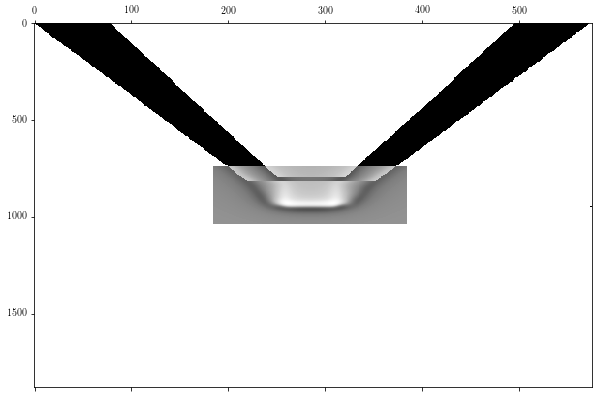

In [7]:
fakemask = mask.copy()
cut = 80
width = 20
startx, endx = 230, 350

fakemask[yc+cut:yc+Ly, xc:xc+Lx] = 0.
fakemask[yc+cut-width:yc+cut, startx:endx] = np.ones((width,endx-startx))

fig, ax = plt.subplots(1,1, figsize=(10,10))
interpmask = 2.*fakemask-1
align = interpmask.copy()
yc1, xc1 = np.array(fake_offset)-np.array([0,0])
align[yc1:yc1+Ly, xc1:xc1+Lx] *= fakescan

lim = np.abs(fakescan).max()
ax.matshow(align, cmap='Greys', aspect=0.2, vmin=-lim, vmax=lim)

In [8]:
netmodel = ResistorNetworkModel(fakemask, phi_offset = [yc1, xc1], 
                                gshape=(Ly, Lx), electrodes=[50,550])

No kernel attribute



## Fitting TV model

In [9]:
param_dict = {'psf_params': fake_psf,
              'J_ext': np.array([np.max(fake_g)/np.max(netmodel.gfield)]), 
              'sigma': np.array([0.02])}

In [10]:
model = FluxModelTVPrior(fakedata, param_dict = param_dict, extmodel = netmodel, 
                         mu_reg = .5,  dx=2., padding = (0,0))#(10, 6))

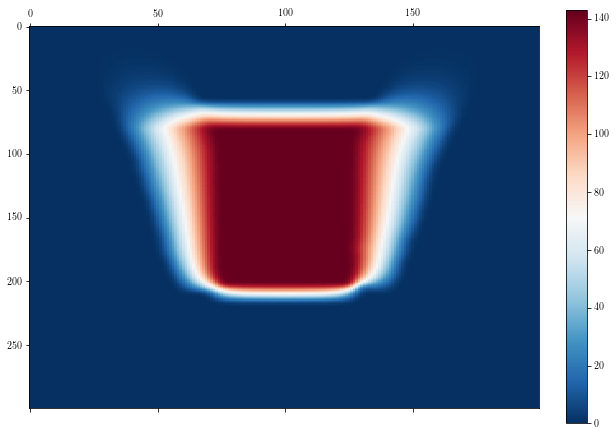

(<matplotlib.figure.Figure at 0x7faa60cec8d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7faaa34e0590>)

In [13]:
py, px = model.py, model.px
Ly_pad, Lx_pad = model.Ly_pad, model.Lx_pad
oy, ox = fake_offset
true_g = fake_g_all[oy-py:oy-py+Ly_pad,
                    ox-px:ox-px+Lx_pad]*fake_J_ext[0]/norm
realg = true_g.ravel()- model.extmodel.ext_g.ravel()#+0.001*np.random.randn(model.N_pad)
matshow(realg.reshape(model.Ly_pad,-1), 0.5)

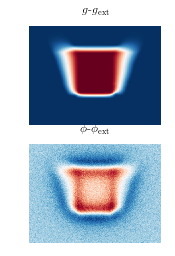

In [14]:
fig, axes = plt.subplots(2,1)
axes[0].matshow(realg.reshape(model.Ly_pad,-1), aspect = 0.5)
axes[0].set_title('$g$-$g_\mathrm{ext}$'); axes[0].axis('off')
axes[1].matshow((model.fluxdataflat-
                 model.crop(model.extmodel.ext_flux.ravel())).reshape(model.Ly,-1),
                aspect = 0.5); axes[1].axis('off')
axes[1].set_title('$\phi$-$\phi_{\mathrm{ext}}$')
#plt.savefig('../docs/2016aps/figs/g-gext.pdf', dpi=200)

In [15]:
admm = LinearModelTV_ADMM(model, rho = 1E-1, mu_reg = 1)
admm.sigma = model.sigma
startg = np.random.randn(model.N_pad)/np.sqrt(model.N_pad)

In [14]:
fitflux = model.fluxdataflat-model.crop(model.extmodel.ext_flux.ravel())
#startg = realg + 1E-8*np.random.randn(model.N_pad)
#startg = np.random.randn(model.N_pad)/np.sqrt(model.N_pad)
admm.computeNLL(fitflux, startg, model.extmodel.ext_g.ravel())

gmin = admm.solve(fitflux, startg, extmodel = model.extmodel,
                  itnlim = 1, iprint = 2, abs_tol = 1E-6, rel_tol = 1E-6)

Initial NLL = 6704217.05141
	Itn 0: NLL = 5.540869e+06, r = 2.512e+07,  s = 3.295e-01, eps_p = 2.509e+01, eps_d = 2.449e-04
Final NLL = 5540869.2535


In [16]:
fitflux_sub = model.fluxdataflat-model.crop(model.extmodel.ext_flux.ravel())

In [17]:
decon0 = deconvolve.TVDeconvolver(model.kernel, admm.mu, 
                                  g_ext = model.extmodel.ext_g)

In [21]:
from scipy.sparse.linalg import eigsh

In [19]:
mtm = decon0.M.T.dot(decon0.M)

In [100]:
w, v = eigsh(mtm, 800)

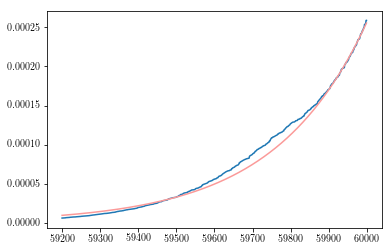

In [125]:
xx = np.arange(mtm.shape[0])[-len(w):]
plt.plot(xx, w)
plt.plot(xx, np.exp(m*xx+b))

In [124]:
x = np.arange(mtm.shape[0])[-100:]
m, b = np.polyfit(x, np.log(w[-100:]), 1)

In [93]:
x.shape

(59600,)

(0, 25)

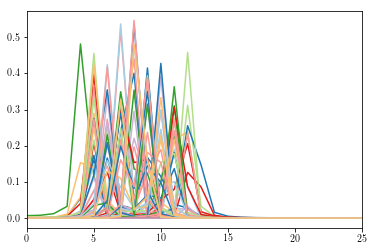

In [56]:
[plt.plot(np.abs(np.fft.fft(v[:,i].reshape(Ly_pad, Lx_pad)[150]))**2) for i in range(v.shape[1])]
plt.xlim([0,25])

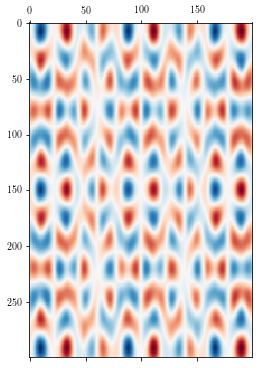

In [122]:
plt.matshow(v[:,-320].reshape(Ly_pad, Lx_pad))

In [22]:
cost0 = []
def callback0(x, z, y, costlist = cost0, **kwargs):
    costlist += [decon0.cost(x, decon0.A.dot(x)-decon0.c, (fitflux_sub,))]

gsol0 = decon0.deconvolve(fitflux_sub, startg, iprint = 2, itnlim = 80, rho=admm.mu/5.,
                          eps_abs = 1E-6, eps_rel=1E-6, algorithm='minimize',
                          callback = callback0)

Initial cost = 2.758e+03
Itn 0: cost = 1.639e+05, rho = 0.00032
	r = 1.228e+12, s = 2.741e-01 
Itn 1: cost = 4.885e+03, rho = 0.00064
	r = 9.907e+04, s = 1.096e+00 
Itn 2: cost = 5.953e+01, rho = 0.00128
	r = 9.495e+03, s = 1.060e-03 
Itn 3: cost = 5.233e+01, rho = 0.00256
	r = 1.442e+03, s = 1.505e-03 
Itn 4: cost = 5.055e+01, rho = 0.00512
	r = 2.614e+02, s = 2.019e-03 
Itn 5: cost = 5.009e+01, rho = 0.01024
	r = 6.156e+01, s = 2.230e-03 
Itn 6: cost = 5.004e+01, rho = 0.02048
	r = 1.493e+01, s = 2.938e-03 
Itn 7: cost = 5.003e+01, rho = 0.04096
	r = 3.882e+00, s = 3.147e-03 
Itn 8: cost = 5.005e+01, rho = 0.08192
	r = 1.151e+00, s = 3.338e-03 
Itn 9: cost = 5.007e+01, rho = 0.16384
	r = 3.245e-01, s = 3.343e-03 
Itn 10: cost = 5.009e+01, rho = 0.32768
	r = 6.928e-02, s = 3.648e-03 
Itn 11: cost = 5.009e+01, rho = 0.32768
	r = 1.411e-02, s = 3.765e-03 
Itn 12: cost = 5.008e+01, rho = 0.32768
	r = 4.620e-03, s = 3.685e-03 
Itn 13: cost = 5.008e+01, rho = 0.32768
	r = 2.656e-03, s = 3.

In [16]:
decon2 = deconvolve.TVDeconvolver(model.kernel, admm.mu,
                                  g_ext = model.extmodel.ext_g)

cost2 = []
def callback2(x, z, y, costlist = cost2, **kwargs):
    costlist += [decon2.cost(x, decon2.A.dot(x)-decon2.c, (fitflux_sub,))]

gsol2 = decon2.deconvolve(fitflux_sub, startg, iprint = 2, itnlim = 30, 
                          eps_abs = 1E-6, eps_rel=1E-6, rho=admm.mu/2.,
                          algorithm='minimize_fastrestart',
                          callback = callback2)

Initial cost = 2.760e+03
Itn 0: cost = 6.637e+04, rho = 0.0008
	r = 1.965e+11, s = 2.747e-01 
		Restarted acceleration
Itn 1: cost = 4.841e+03, rho = 0.0016
	r = 2.181e+04, s = 1.098e+00 
		Restarted acceleration
Itn 2: cost = 1.908e+04, rho = 0.0032
	r = 1.390e+04, s = 4.389e+00 
Itn 3: cost = 6.564e+01, rho = 0.0064
	r = 1.194e+03, s = 2.286e-03 
Itn 4: cost = 5.683e+01, rho = 0.0128
	r = 1.367e+02, s = 3.338e-03 
Itn 5: cost = 5.395e+01, rho = 0.0256
	r = 3.537e+01, s = 5.236e-03 
Itn 6: cost = 5.269e+01, rho = 0.0512
	r = 1.235e+01, s = 7.802e-03 
Itn 7: cost = 5.205e+01, rho = 0.1024
	r = 3.295e+00, s = 1.026e-02 
Itn 8: cost = 5.168e+01, rho = 0.2048
	r = 6.866e-01, s = 1.205e-02 
Itn 9: cost = 5.146e+01, rho = 0.2048
	r = 1.370e-01, s = 1.466e-02 
Itn 10: cost = 5.129e+01, rho = 0.2048
	r = 1.014e-01, s = 1.445e-02 
Itn 11: cost = 5.114e+01, rho = 0.2048
	r = 7.447e-02, s = 1.408e-02 
Itn 12: cost = 5.100e+01, rho = 0.2048
	r = 6.472e-02, s = 1.387e-02 
Itn 13: cost = 5.088e+01,

(0, 40)

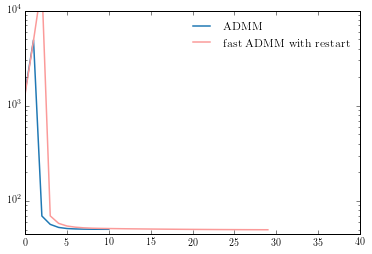

In [20]:
plt.plot(cost0, label="ADMM")
plt.plot(cost2, label="fast ADMM with restart")
plt.legend(loc='best')
plt.yscale('log')
plt.ylim([45,1E4])
plt.xlim([0,40])

#plt.savefig("../plots/2016-12-15-testing-algorithms-fake-data.pdf")

In [18]:
print(decon2.cost(gsol0, -decon2.A.dot(gsol0)+decon0.c, (fitflux_sub,)))
print(decon2.cost(gsol2, -decon2.A.dot(gsol2)+decon2.c, (fitflux_sub,)))
print(decon2.cost(realg.ravel(), -decon2.A.dot(realg.ravel())+decon2.c, (fitflux_sub,)))

50.3688249109
49.8107395476
49.9503872495


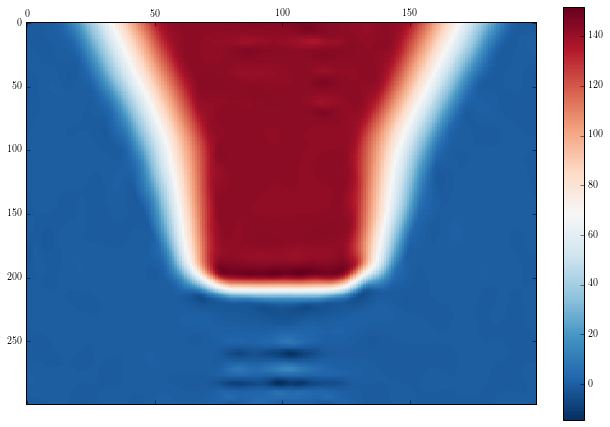

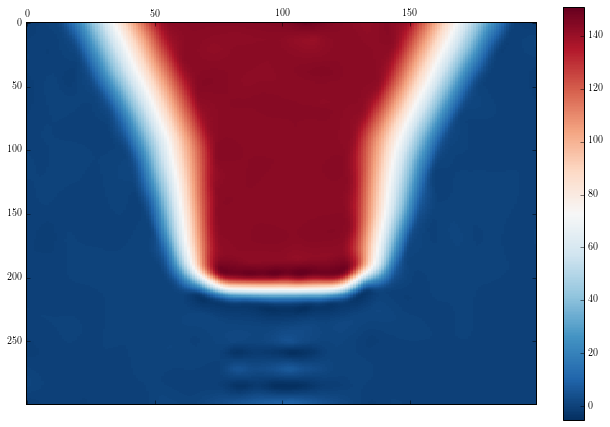

(<matplotlib.figure.Figure at 0x7fd6bcdbe048>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd6bd1db278>)

In [21]:
matshow((gsol0).reshape(model.Ly_pad,-1)+netmodel.ext_g, 0.5)
matshow((gsol2).reshape(model.Ly_pad,-1)+netmodel.ext_g, 0.5)

In [26]:
model.updateParamVector(admm._g, ['gfieldflat'])
model.computeNLL()

-149556.26531529371

In [27]:
reload(fpd)

<module 'pysquid.viz.fake_data_plotting' from '/home/colin/work/rnet/code/pysquid/viz/fake_data_plotting.pyc'>

In [28]:
dfig, daxes = fpd.diagnostic(model, realg.reshape(model.Ly_pad,-1)+netmodel.ext_g, fakedata, admm)
#today = datetime.date(datetime.now()).isoformat()
#plt.savefig('../plots/{}-fake_data_diagnostic_mu-{}.pdf'.format(today, str(admm.mu_reg).replace('.','p')))

AttributeError: 'FluxModelTVPrior' object has no attribute 'modelflux'

In [77]:
np.savez('data/2016-03-03-fake-data-fit.npz', 
         g_sol=model.g_sol, ref_g = realg.reshape(model.Ly_pad,-1)+netmodel.ext_g,
         fit_flux = model.modelflux.reshape(model._shape), ref_flux = model.fluxdata,
         sigma = model.sigma, psf_params = model.kernel.psf_params, PSF=model.kernel.PSF)

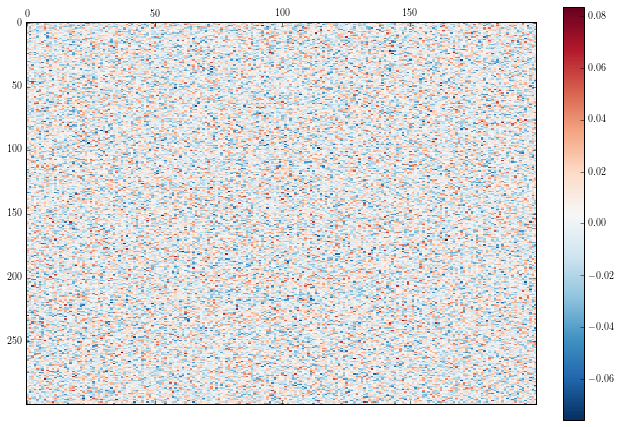

Pred mean: 0.000236388705665, Residual mean: 0.00542242604439 in sigmas


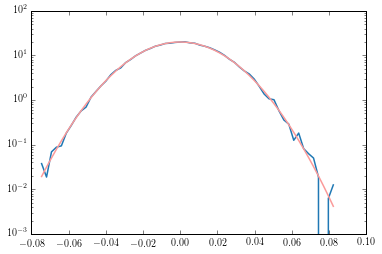

In [79]:
resim = model.residuals[:model.N].reshape(model.Ly, -1)
matshow(resim, aspect=0.5)#, vmin=-0.15, vmax=0.15)

hist, bins = np.histogram(resim, bins=60, density=True)
p = lambda x: np.exp(-(x/model.sigma)**2/2)/np.sqrt(2*np.pi*model.sigma**2)
resp = 0.5*(bins[1:]+bins[:-1])
plt.figure()
plt.plot(resp, hist)
plt.plot(resp, p(resp))
plt.yscale('log')
print("Pred mean: {}, Residual mean: {} in sigmas".format(resp.dot(p(resp)*np.diff(bins))/model.sigma, 
                                                          resp.dot(hist*np.diff(bins))/model.sigma))

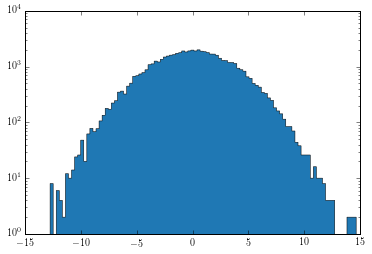

In [95]:
plt.hist(np.fft.fft2(resim).real.ravel(), bins=100, histtype='stepfilled');
plt.yscale('log')

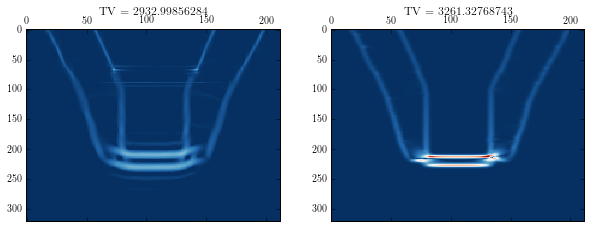

In [331]:
tv_modelg = admm.TV(model.gfield+model.extmodel.ext_g).reshape(model.Ly_pad,-1)
tv_realg = admm.TV(realg+model.extmodel.ext_g.ravel()).reshape(model.Ly_pad,-1)
fig, axes = plt.subplots(1,2, figsize=(10,5))
lim = max(tv_modelg.max(), tv_realg.max())
axes[0].matshow(tv_modelg, aspect=0.5, vmin=0, vmax=lim)
axes[0].set_title("TV = {}".format(tv_modelg.sum()))
axes[1].matshow(tv_realg, aspect=0.5, vmin=0, vmax = lim)
axes[1].set_title("TV = {}".format(tv_realg.sum()))

## Finite support

### Todo:


In [22]:
import scipy.ndimage as ndi

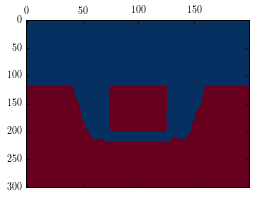

In [23]:
supportmask = mask[yc:yc+Ly_pad, xc:xc+Lx_pad]
#plt.matshow(supportmask, aspect=1/2.)
zeromask = ndi.binary_erosion(1*(supportmask == 0), iterations=2,
                              border_value=1)
zeromask[:120] = 0.
plt.matshow(zeromask, aspect=0.5)

In [24]:
decon_fs = deconvolve.TVFiniteSupportDeconvolve(model.kernel, admm.mu, zeromask,
                                                g_ext = model.extmodel.ext_g)

In [25]:
costfs = []
def callback(x, z, y, costlist = costfs, **kwargs):
    costlist += [decon_fs.cost(x, z, g_args = (fitflux_sub,))]
N = model.kernel.N_pad
options = {'rho' : admm.mu/20,}
gsol = decon_fs.deconvolve(fitflux_sub, np.random.randn(N)/np.sqrt(N), 
                           options = options,
                           iprint = 2, itnlim = 30, 
                           eps_abs = 1E-7, eps_rel=1E-7, rho = 1E-6,
                           algorithm='minimize', callback = callback)

Initial cost = 2.758e+03
	Initial cost = 2.760e+03
	Convergence criterion satisfied
	Final cost = 1.469e+02
Itn 0: cost = 6.315e+01, rho = 2e-06
	r = 1.690e+08, s = 1.690e-04 
	Initial cost = 6.406e+01
	Convergence criterion satisfied
	Final cost = 5.421e+01
Itn 1: cost = 5.378e+01, rho = 4e-06
	r = 3.273e+07, s = 1.002e-05 
	Initial cost = 5.344e+01
	Convergence criterion satisfied
	Final cost = 5.137e+01
Itn 2: cost = 5.198e+01, rho = 8e-06
	r = 1.751e+05, s = 4.495e-06 
	Initial cost = 5.140e+01
	Convergence criterion satisfied
	Final cost = 5.069e+01
Itn 3: cost = 5.134e+01, rho = 1.6e-05
	r = 2.616e+04, s = 2.732e-06 
	Initial cost = 5.075e+01
	Convergence criterion satisfied
	Final cost = 5.036e+01
Itn 4: cost = 5.098e+01, rho = 3.2e-05
	r = 1.293e+04, s = 2.728e-06 
	Initial cost = 5.046e+01
	Convergence criterion satisfied
	Final cost = 5.018e+01
Itn 5: cost = 5.080e+01, rho = 6.4e-05
	r = 4.546e+03, s = 4.542e-06 
	Initial cost = 5.027e+01
	Convergence criterion satisfied
	Fin

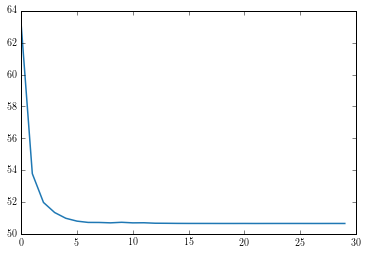

In [29]:
plt.plot(costfs)#;plt.yscale('log')

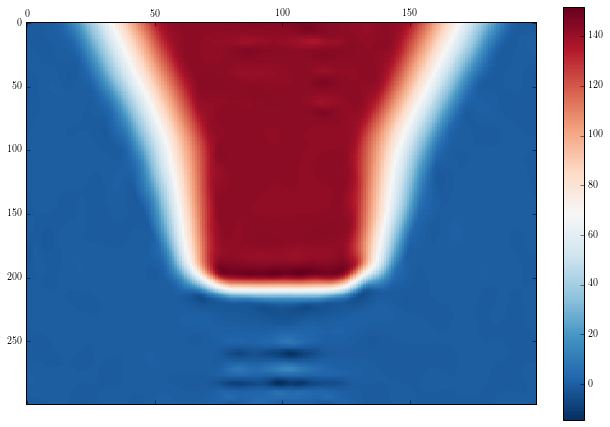

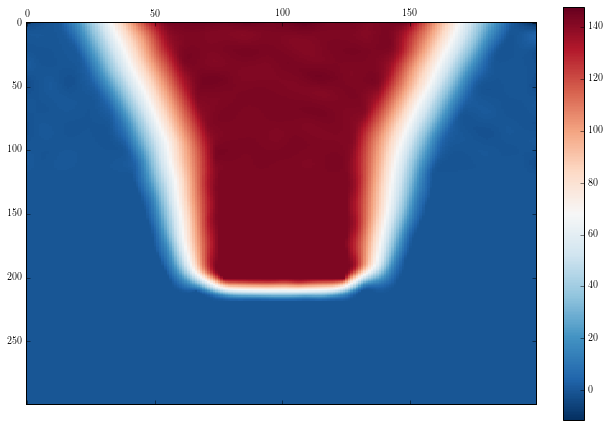

(<matplotlib.figure.Figure at 0x7fd6bd161f60>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd6bd066080>)

In [32]:
matshow((gsol0).reshape(Ly_pad, Lx_pad)+netmodel.ext_g, 0.5)
matshow((gsol).reshape(Ly_pad, Lx_pad)+netmodel.ext_g, 0.5)

In [33]:
print(decon_fs.g(gsol, (fitflux_sub)))
print(decon_fs.g(gsol0, (fitflux_sub)))
print(decon_fs.g(realg, (fitflux_sub)))

50.6534487757
51.2354119593
50.7646237303
